<a href="https://colab.research.google.com/github/wenjunsun/personal-machine-learning-projects/blob/master/deep-learning/nn_predict_wine_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The wine quality data is a public dataset. Here I am using the dataset in [deep learning pytorch book github](https://github.com/deep-learning-with-pytorch/dlwpt-code/tree/master/data/p1ch4/tabular-wine)

In [ ]:
import pandas as pd

In [ ]:
cd drive/MyDrive/dlwpt-code/data/p1ch4/tabular-wine/

/content/drive/MyDrive/dlwpt-code/data/p1ch4/tabular-wine


In [ ]:
ls

winequality-white.csv


# 0. read wine data into dataframe

In [ ]:
data = pd.read_csv('winequality-white.csv', delimiter=';')

In [ ]:
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


# 1. TSNE to visualize data

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(learning_rate = 50)

In [ ]:
tsne_features = tsne.fit_transform(data)

In [ ]:
tsne_features

array([[ 40.201855 , -13.077791 ],
       [ -1.872281 ,   3.7792146],
       [-49.23745  ,  12.257515 ],
       ...,
       [-25.830532 ,  29.393171 ],
       [-28.638065 ,   8.763258 ],
       [-41.0672   ,   1.2731032]], dtype=float32)

In [ ]:
df = pd.DataFrame()

In [ ]:
df['x'] = tsne_features[:, 0]

In [ ]:
df['y'] = tsne_features[:, 1]

In [ ]:
import seaborn as sns

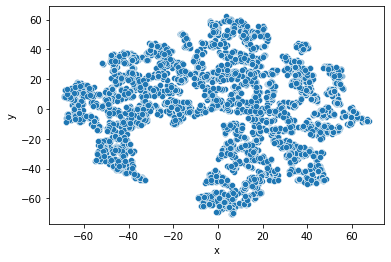

In [ ]:
sns.scatterplot(x = "x", y = "y", data = df)

In [ ]:
df['free sulfur dioxide'] = data['free sulfur dioxide'].apply(lambda x: "high" if x > 30 else "low")

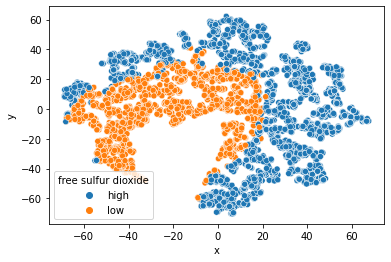

In [ ]:
sns.scatterplot(x = "x", y = "y", hue = 'free sulfur dioxide',data = df)

In [ ]:
df['alcohol'] = data['alcohol'].apply(lambda x: "high" if x > 10 else "low")

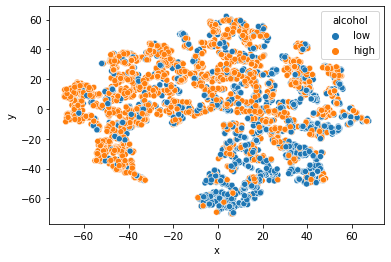

In [ ]:
sns.scatterplot(x = "x", y = "y", hue = 'alcohol',data = df)

This is pretty cool! T-SNE can embed multi-dimensional data into 2/3 dimensions according to some distances rules! It seems for our dataset T-SNE seprates `free sulfur dioxide` column pretty well! This might suggest `free sulfur dioxide` is an important feature. There are many other ways to visualize high dimensional data and this is one of them.

# 2. prepare tensors for neural net

In [ ]:
import torch

In [ ]:
# need to convert dataframe into tensors.
data_tensor = torch.tensor(data.values, dtype = torch.float32)

In [ ]:
y = data_tensor[:, -1]

In [ ]:
x = data_tensor[:, :-1]

In [ ]:
x

tensor([[ 7.0000,  0.2700,  0.3600,  ...,  3.0000,  0.4500,  8.8000],
        [ 6.3000,  0.3000,  0.3400,  ...,  3.3000,  0.4900,  9.5000],
        [ 8.1000,  0.2800,  0.4000,  ...,  3.2600,  0.4400, 10.1000],
        ...,
        [ 6.5000,  0.2400,  0.1900,  ...,  2.9900,  0.4600,  9.4000],
        [ 5.5000,  0.2900,  0.3000,  ...,  3.3400,  0.3800, 12.8000],
        [ 6.0000,  0.2100,  0.3800,  ...,  3.2600,  0.3200, 11.8000]])

In [ ]:
y.unsqueeze_(1)

tensor([[6.],
        [6.],
        [6.],
        ...,
        [6.],
        [7.],
        [6.]])

In [ ]:
x.shape

torch.Size([4898, 11])

In [ ]:
y.shape

torch.Size([4898, 1])

# 3. train neural net

In [ ]:
import torch.nn as nn
import torch.optim as optim

In [ ]:
random_indices = torch.randperm(x.size()[0])

In [ ]:
random_indices

tensor([2475, 1908, 4643,  ..., 3215, 2606,  115])

In [ ]:
size_of_training_set = int(x.size()[0] * 0.75)

In [ ]:
x_train = x[random_indices[:size_of_training_set]]
y_train = y[random_indices[:size_of_training_set]]
x_validation = x[random_indices[size_of_training_set:]]
y_validation = y[random_indices[size_of_training_set:]]

In [ ]:
x_train.shape

torch.Size([3673, 11])

In [ ]:
sequential_model = nn.Sequential(nn.Linear(11, 10),
                                 nn.LeakyReLU(),
                                 nn.Linear(10, 1))

In [ ]:
optimizer = optim.Adam(sequential_model.parameters())

In [ ]:
def training_loop(num_epochs, optimizer, model, loss_function, x_train, y_train,
                  x_validation, y_validation):
  for curr_epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()

    y_pred = model(x_train)
    train_loss = loss_function(y_pred, y_train)
    train_loss.backward()

    optimizer.step() # update parameters this optimizer owns via GD

    with torch.no_grad(): # to calculate validation loss we don't want to keep track of gradients!
      validate_loss = loss_function(model(x_validation), y_validation)

    if curr_epoch % 1000 == 0:
      print(f'at epoch {curr_epoch} in the training, train loss is {train_loss}')
      print(f'at epoch {curr_epoch} in the training, validation loss is {validate_loss}')

In [ ]:
training_loop(num_epochs=10000,
              optimizer = optimizer,
              model = sequential_model,
              loss_function = nn.MSELoss(),
              x_train = x_train,
              y_train = y_train,
              x_validation = x_validation,
              y_validation = y_validation)

at epoch 1000 in the training, train loss is 0.6242562532424927
at epoch 1000 in the training, validation loss is 0.6532347202301025
at epoch 2000 in the training, train loss is 0.5930020213127136
at epoch 2000 in the training, validation loss is 0.6231493353843689
at epoch 3000 in the training, train loss is 0.5691903233528137
at epoch 3000 in the training, validation loss is 0.5999209880828857
at epoch 4000 in the training, train loss is 0.5433608293533325
at epoch 4000 in the training, validation loss is 0.5570428967475891
at epoch 5000 in the training, train loss is 0.536593496799469
at epoch 5000 in the training, validation loss is 0.5521010756492615
at epoch 6000 in the training, train loss is 0.5335331559181213
at epoch 6000 in the training, validation loss is 0.5522950291633606
at epoch 7000 in the training, train loss is 0.5324839353561401
at epoch 7000 in the training, validation loss is 0.5529035925865173
at epoch 8000 in the training, train loss is 0.5316399931907654
at epo

Based on this we can see at least our model isn't overfitting that much as train loss is pretty close to validatoin loss. We just don't know if this is the best model we have. is `0.55` of loss good enough for this problem? This is an interesting problem that I might need to consult wine quality literatures.

## try more layers.

In [ ]:
sequential_model = nn.Sequential(nn.Linear(11, 10),
                                 nn.LeakyReLU(),
                                 nn.Linear(10, 10),
                                 nn.LeakyReLU(),
                                 nn.Linear(10, 10),
                                 nn.LeakyReLU(),
                                 nn.Linear(10, 1))

In [ ]:
optimizer = optim.Adam(sequential_model.parameters())

In [ ]:
training_loop(num_epochs=10000,
              optimizer = optimizer,
              model = sequential_model,
              loss_function = nn.MSELoss(),
              x_train = x_train,
              y_train = y_train,
              x_validation = x_validation,
              y_validation = y_validation)

at epoch 1000 in the training, train loss is 0.547632098197937
at epoch 1000 in the training, validation loss is 0.5692722797393799
at epoch 2000 in the training, train loss is 0.5256115794181824
at epoch 2000 in the training, validation loss is 0.5626227855682373
at epoch 3000 in the training, train loss is 0.5200189352035522
at epoch 3000 in the training, validation loss is 0.5607399940490723
at epoch 4000 in the training, train loss is 0.5122979879379272
at epoch 4000 in the training, validation loss is 0.5551378130912781
at epoch 5000 in the training, train loss is 0.5102636814117432
at epoch 5000 in the training, validation loss is 0.5570101737976074
at epoch 6000 in the training, train loss is 0.5092114806175232
at epoch 6000 in the training, validation loss is 0.5598181486129761
at epoch 7000 in the training, train loss is 0.5096672773361206
at epoch 7000 in the training, validation loss is 0.5644022226333618
at epoch 8000 in the training, train loss is 0.5073519945144653
at epo

A slight overfitting in this case.

## try more neurons in a layer

In [ ]:
sequential_model = nn.Sequential(nn.Linear(11, 50),
                                 nn.LeakyReLU(),
                                 nn.Linear(50, 1))

In [ ]:
optimizer = optim.Adam(sequential_model.parameters())

In [ ]:
training_loop(num_epochs=10000,
              optimizer = optimizer,
              model = sequential_model,
              loss_function = nn.MSELoss(),
              x_train = x_train,
              y_train = y_train,
              x_validation = x_validation,
              y_validation = y_validation)

at epoch 1000 in the training, train loss is 0.5576329231262207
at epoch 1000 in the training, validation loss is 0.572085976600647
at epoch 2000 in the training, train loss is 0.5330302119255066
at epoch 2000 in the training, validation loss is 0.5534883141517639
at epoch 3000 in the training, train loss is 0.5286426544189453
at epoch 3000 in the training, validation loss is 0.554317831993103
at epoch 4000 in the training, train loss is 0.5271828770637512
at epoch 4000 in the training, validation loss is 0.5552952885627747
at epoch 5000 in the training, train loss is 0.525387704372406
at epoch 5000 in the training, validation loss is 0.5550822615623474
at epoch 6000 in the training, train loss is 0.5237308740615845
at epoch 6000 in the training, validation loss is 0.5541430711746216
at epoch 7000 in the training, train loss is 0.5231396555900574
at epoch 7000 in the training, validation loss is 0.5553235411643982
at epoch 8000 in the training, train loss is 0.5217360854148865
at epoch

Doesn't help much either..

## try a different activation

In [ ]:
sequential_model = nn.Sequential(nn.Linear(11, 50),
                                 nn.Tanh(),
                                 nn.Linear(50, 1))

In [ ]:
optimizer = optim.Adam(sequential_model.parameters())

In [ ]:
training_loop(num_epochs=10000,
              optimizer = optimizer,
              model = sequential_model,
              loss_function = nn.MSELoss(),
              x_train = x_train,
              y_train = y_train,
              x_validation = x_validation,
              y_validation = y_validation)

at epoch 1000 in the training, train loss is 0.5494011640548706
at epoch 1000 in the training, validation loss is 0.5848277807235718
at epoch 2000 in the training, train loss is 0.5114176869392395
at epoch 2000 in the training, validation loss is 0.5471480488777161
at epoch 3000 in the training, train loss is 0.4960041046142578
at epoch 3000 in the training, validation loss is 0.5365855693817139
at epoch 4000 in the training, train loss is 0.48711857199668884
at epoch 4000 in the training, validation loss is 0.531939685344696
at epoch 5000 in the training, train loss is 0.4818282723426819
at epoch 5000 in the training, validation loss is 0.5298964381217957
at epoch 6000 in the training, train loss is 0.47726723551750183
at epoch 6000 in the training, validation loss is 0.5285102725028992
at epoch 7000 in the training, train loss is 0.47296062111854553
at epoch 7000 in the training, validation loss is 0.5287008881568909
at epoch 8000 in the training, train loss is 0.46928349137306213
at

`Tanh` is slightly better than `leakyRelu` in this problem

# conclusion

- T-SNE is a way to project high dimensional data into low dimensions (2/3) for visualization. The way it is done it that such that points in original space that are close to each other should be closer to each other after reducing dimension. This is a great way for visualizing multi-dimensional data. **T-SNE training takes a relatively long time**
- Neural net training on `4000 x 11` dataset gets slow as we add more parameters. If NN has 100 parameters it takes about 1 minute to train 10000 iterations. This is a small dataset and small amount of parameters for modern DL frameworks. Need to use GPU if want to train more powerful networks.